<a href="https://colab.research.google.com/github/adirsonmfjr/credito-rural/blob/main/Artigo_02_Cru_Geral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import requests
import pandas as pd
from io import BytesIO
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# URL do novo arquivo no GitHub
url = "https://raw.githubusercontent.com/adirsonmfjr/credito-rural/main/Dados_Estoque_credito_rural_1993-2023.xls"

# Baixar o arquivo
response = requests.get(url)

if response.status_code == 200:
    # Carregar o Excel com ajustes
    df = pd.read_excel(
        BytesIO(response.content),
        sheet_name="Séries",  # Nome da aba no Excel
        engine="xlrd",
        dtype=str  # Lê como string para evitar conversões erradas
    )

    # Converter colunas numéricas para float e substituir NaN por 0
    for col in df.columns[3:]:  # Pular as três primeiras colunas (Sigla, Código, Município)
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    print("Arquivo carregado com sucesso!")

else:
    print("Erro ao baixar o arquivo:", response.status_code)

# Configurar pandas para exibir valores sem notação científica
pd.set_option('display.float_format', '{:,.0f}'.format)

# Exibir as primeiras linhas para verificar se faz sentido
df.head()


Arquivo carregado com sucesso!


,Sigla,Codigo,Município,1993,1994,1995,1996,1997,1998,1999,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,AC,1200013,Acrelândia,0,0,21749,5083039,1180168,3603147,3962375,...,20776771,8562961,11362390,11235470,14613649,15877934,9088736,8996591,6580221,4908745
1,AC,1200054,Assis Brasil,125701,1764378,294535,0,0,244387,688827,...,3197656,35660,334018,5179684,1636721,924183,297710,524263,112330,151097
2,AC,1200104,Brasiléia,6372470,5486466,3067611,486008,818832,1006212,2966766,...,8906259,9917391,16527385,13863737,11236307,10363271,7850346,3423072,3098155,3913477
3,AC,1200138,Bujari,0,0,569863,13844,108046,293693,635708,...,16035479,18792652,9158576,10670679,17666324,14845991,6806347,9281610,4009833,3910707
4,AC,1200179,Capixaba,0,0,0,0,104771,560449,0,...,4519761,3421325,4075607,3578121,11337150,6119740,3826153,2452279,6232797,3550908


# Parte 2 - Cálculo das Métricas RFM

In [47]:
import pandas as pd

# Supondo que df já esteja carregado

# Identificar as colunas de anos (ignorar colunas categóricas)
colunas_anos = [col for col in df.columns if col.isdigit()]  # Filtra apenas colunas com nome numérico

# Criar colunas de Data Inicial e Data Final
df["Data_Inicial"] = int(min(colunas_anos))  # Primeiro ano disponível na base
df["Data_Final"] = int(max(colunas_anos))    # Último ano disponível na base

# Função para calcular a Recência (R), garantindo que não seja zero
def calcular_recencia(row):
    anos_com_estoque = [int(ano) for ano in colunas_anos if row[ano] > 0]  # Filtra os anos com estoque positivo
    if anos_com_estoque:
        return max(1, df["Data_Final"].iloc[0] - max(anos_com_estoque))  # Último ano com estoque - Data Final (mínimo 1)
    return max(1, df["Data_Final"].iloc[0] - df["Data_Inicial"].iloc[0])  # Caso não haja estoque em nenhum ano

# Aplicar a função de Recência
df["Recencia"] = df.apply(calcular_recencia, axis=1)

# Criar a coluna de Frequência (F) - Contagem de anos com estoque positivo
df["Frequencia"] = (df[colunas_anos] > 0).sum(axis=1)

# Criar a coluna Monetário (M) - Soma total dos estoques ao longo do período
df["Monetario"] = df[colunas_anos].sum(axis=1)

# Criar a coluna de Longevidade (L) como o intervalo entre o primeiro e o último ano com crédito
def calcular_longevidade(row):
    anos_validos = [int(ano) for ano in colunas_anos if row[ano] > 0]  # Filtra os anos com crédito positivo
    if anos_validos:
        return max(anos_validos) - min(anos_validos)  # Último ano - Primeiro ano
    return 0  # Caso nunca tenha pego crédito

# Aplicar a função para calcular Longevidade
df["Longevidade"] = df.apply(calcular_longevidade, axis=1)

# Salvar o DataFrame no Colab
df.to_csv("/content/df_rfm.csv", index=False)

# Exibir as métricas RFM e Longevidade
df[["Recencia", "Frequencia", "Monetario", "Longevidade"]].head(15)

,Recencia,Frequencia,Monetario,Longevidade
0,1,29,231741082,28
1,1,29,41216925,30
2,1,31,177560391,30
3,1,29,257391191,28
4,1,26,98085601,26
5,1,31,73294608,30
6,1,26,62018956,26
7,1,30,64958872,30
8,1,14,1310817,23
9,1,25,17574727,24


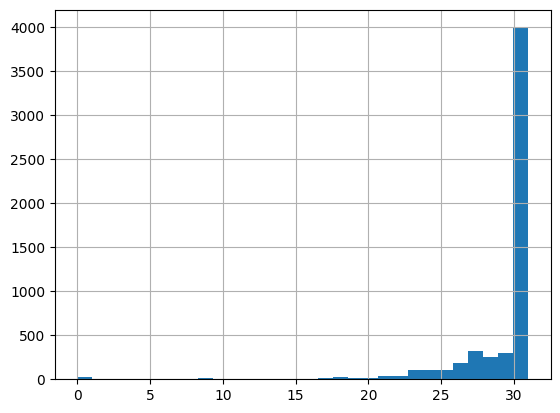

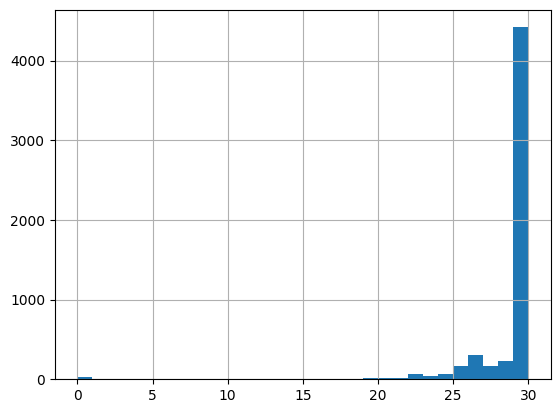

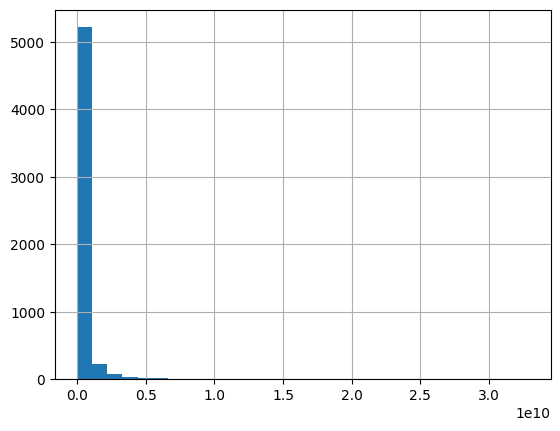

In [39]:
import matplotlib.pyplot as plt
df['Frequencia'].hist(bins=30)
plt.show()

import matplotlib.pyplot as plt
df['Longevidade'].hist(bins=30)
plt.show()

import matplotlib.pyplot as plt
df['Monetario'].hist(bins=30)
plt.show()


In [61]:
import pandas as pd
import numpy as np  # Adiciona ruído para evitar valores idênticos em qcut()

# Carregar o DataFrame salvo anteriormente no Colab
df = pd.read_csv("/content/df_rfm.csv")

# Função para criar quintis corretamente
def criar_quintis(column, invert=False):
    unique_values = column.nunique()

    # Evita erro de bordas duplicadas adicionando ruído pequeno
    column = column + np.random.uniform(0, 0.01, size=len(column))

    # Se os valores forem poucos, usa pd.cut()
    if unique_values < 5:
        if invert:
            return pd.cut(column.rank(method='first', ascending=False), bins=unique_values, labels=range(5, 5 - unique_values, -1)).astype(int)
        return pd.cut(column.rank(method='first'), bins=unique_values, labels=range(1, unique_values + 1)).astype(int)

    # Se houver valores suficientes, usa pd.qcut() com `duplicates='drop'`
    if invert:
        return pd.qcut(column, q=5, labels=[5, 4, 3, 2, 1], duplicates="drop").astype(int)
    return pd.qcut(column, q=5, labels=[1, 2, 3, 4, 5], duplicates="drop").astype(int)

# Criar escores por quintil para RFM e Longevidade
df["Recencia_Score"] = criar_quintis(df["Recencia"], invert=True)  # Menor Recência é melhor (inverte labels)
df["Frequencia_Score"] = criar_quintis(df["Frequencia"])
df["Monetario_Score"] = criar_quintis(df["Monetario"])
df["Longevidade_Score"] = criar_quintis(df["Longevidade"])

# Salvar o DataFrame atualizado no Colab
df.to_csv("/content/df_rfm_scores.csv", index=False)

# Exibir as métricas RFM, Longevidade e escores
df[["Recencia", "Frequencia", "Monetario", "Longevidade", "Recencia_Score", "Frequencia_Score", "Monetario_Score", "Longevidade_Score"]].head(15)


,Recencia,Frequencia,Monetario,Longevidade,Recencia_Score,Frequencia_Score,Monetario_Score,Longevidade_Score
0,1,29,231741082,28,1,2,4,2
1,1,29,41216925,30,3,2,2,3
2,1,31,177560391,30,1,4,4,3
3,1,29,257391191,28,5,2,4,2
4,1,26,98085601,26,1,1,3,1
5,1,31,73294608,30,3,4,3,2
6,1,26,62018956,26,3,1,3,1
7,1,30,64958872,30,2,2,3,5
8,1,14,1310817,23,4,1,1,1
9,1,25,17574727,24,1,1,1,1


In [80]:
import pandas as pd

# 1) Carregue o DataFrame que já possui:
df = pd.read_csv("/content/df_rfm_scores.csv")

# 2) Criar a média de Frequência e Longevidade com valores float
df["F_L_Media"] = (df["Frequencia_Score"] + df["Longevidade_Score"]) / 2

# 3) Calcular o score final ponderado
df["Weighted_Score"] = (
      0.50 * df["F_L_Media"]  # Média de F + L
    + 0.50 * df["Monetario_Score"]
)

# 4) Classificar usando as novas faixas:
#    0 = "Sem classificação"
#    (0, 1] = "Baixa"
#    (1, 2] = "Média-baixa"
#    (2, 3] = "Média"
#    (3, 4] = "Média-alta"
#    (4, 5] = "Alta"
df["Weighted_Label"] = pd.cut(
    df["Weighted_Score"],
    bins=[-0.1, 0, 1, 2, 3, 4, 5],   # Incluí -0.1 para garantir que 0 seja capturado corretamente
    labels=["Sem classificação", "Baixa", "Média-baixa", "Média", "Média-alta", "Alta"],
    include_lowest=True
)

# 5) Garantir pelo menos uma casa decimal na exibição dos números
df["F_L_Media"] = df["F_L_Media"].map(lambda x: f"{x:.1f}")  # Formata com pelo menos 1 casa decimal
df["Weighted_Score"] = df["Weighted_Score"].map(lambda x: f"{x:.1f}")  # Formata com pelo menos 1 casa decimal

# Exibir as colunas relevantes
display(df[[
    "Frequencia_Score",
    "Longevidade_Score",
    "F_L_Media",  # Agora formatado corretamente
    "Monetario_Score",
    "Weighted_Score",
    "Weighted_Label"
]].head(15))

# Se quiser salvar o DataFrame final:
df.to_csv("/content/df_rfm_scores_weighted.csv", index=False)


,Frequencia_Score,Longevidade_Score,F_L_Media,Monetario_Score,Weighted_Score,Weighted_Label
0,2,2,2.0,4,3.0,Média
1,2,3,2.5,2,2.2,Média
2,4,3,3.5,4,3.8,Média-alta
3,2,2,2.0,4,3.0,Média
4,1,1,1.0,3,2.0,Média-baixa
5,4,2,3.0,3,3.0,Média
6,1,1,1.0,3,2.0,Média-baixa
7,2,5,3.5,3,3.2,Média-alta
8,1,1,1.0,1,1.0,Baixa
9,1,1,1.0,1,1.0,Baixa


Distribuição do Weighted_Label:


,count
Weighted_Label,
Alta,1041
Baixa,496
Média,1374
Média-alta,1756
Média-baixa,929


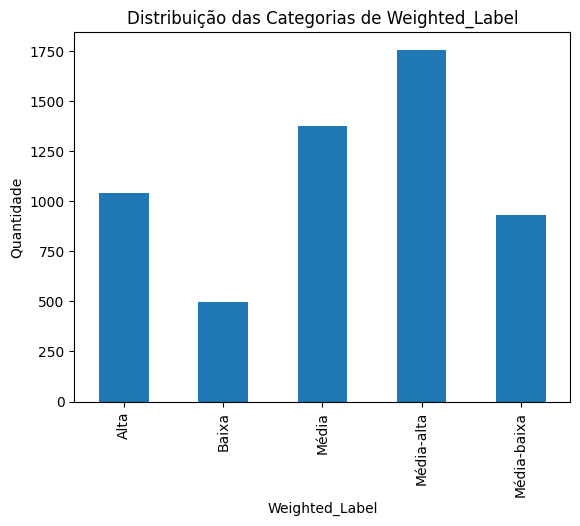

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Carregar o DataFrame final com Weighted_Label (já contém "Weighted_Score" e "Weighted_Label")
df = pd.read_csv("/content/df_rfm_scores_weighted.csv")

# 2) Criar uma tabela com a contagem de cada categoria
count_table = df["Weighted_Label"].value_counts().sort_index()

# 3) Exibir a tabela
print("Distribuição do Weighted_Label:")
display(count_table)

# 4) Plotar um gráfico de barras
count_table.plot(kind='bar')
plt.xlabel("Weighted_Label")
plt.ylabel("Quantidade")
plt.title("Distribuição das Categorias de Weighted_Label")
plt.show()


In [ ]:
Mapa

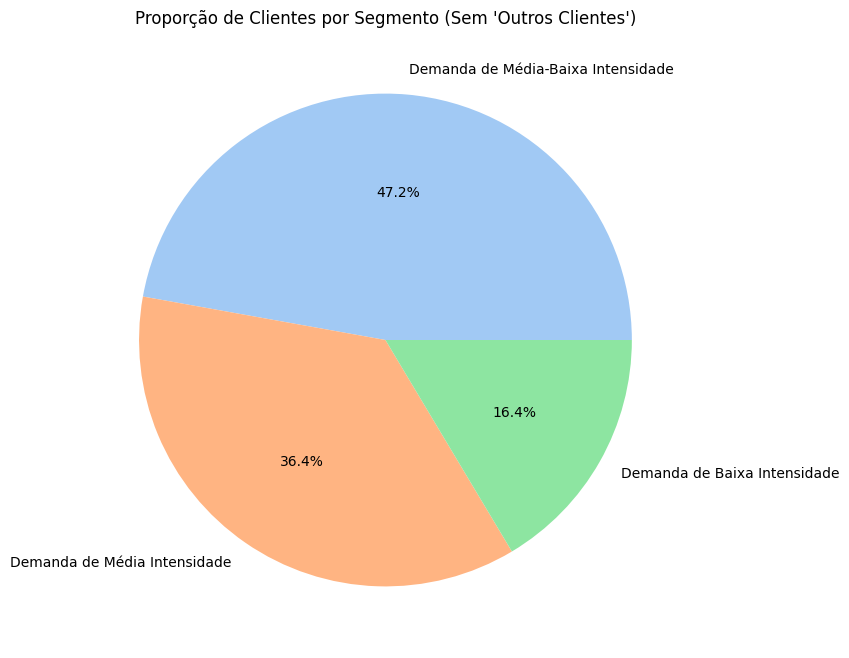

In [ ]:
plt.figure(figsize=(8, 8))
rfm_filtrado["classificacao_LFM"].value_counts().plot.pie(autopct="%1.1f%%", colors=sns.color_palette("pastel"))
plt.title("Proporção de Clientes por Segmento (Sem 'Outros Clientes')")
plt.ylabel("")
plt.show()
